# BankingRiskAssessment: ML-Based Customer Risk Analysis

Two data sets are defined according to the ID status of our customers in this data set.

The first data set is defined as application_record and detailed information is provided below.

* application_record : Gender, income, age, working hours, etc. All the columns are quite self-explanatory while it contains all the information about the user characteristics such as, the column containing data such as age and working hours has a negative value which tells how many days they have worked.

    * ID	Client number	
    * CODE_GENDER	Gender / Cinsiyet
    * FLAG_OWN_CAR	Is there a car / Arabası var mı?	
    * FLAG_OWN_REALTY	Is there a property	/ Bir mülkü var mı?
    * CNT_CHILDREN	Number of children	/ Çocuk sayısı
    * AMT_INCOME_TOTAL	Annual income	/ Yıllık geliri
    * NAME_INCOME_TYPE	Income category	/ Gelir tipi
    * NAME_EDUCATION_TYPE	Education level	/ Eğitim seviyesi
    * NAME_FAMILY_STATUS	Marital status	/ Medeni durumu
    * NAME_HOUSING_TYPE	Way of living	/ Ev Tipi
    * DAYS_BIRTH	Birthday	Count backwards from current day (0), -1 means yesterday / Doğum günü
    * DAYS_EMPLOYED	Start date of employment	
        * Count backwards from current day(0). If positive, it means the person currently unemployed.
    * FLAG_MOBIL	Is there a mobile phone	 / Cep telefonu var mı?
    * FLAG_WORK_PHONE	Is there a work phone	/ İş telefonu var mı?
    * FLAG_PHONE	Is there a phone	/ Telefonu var mı?
    * FLAG_EMAIL	Is there an email	/ Email var mı?
    * OCCUPATION_TYPE	Occupation	/ Meslek
    * CNT_FAM_MEMBERS	Family size / Aile büyüklüğü


* credit_record : Kullanıcı etkinliği ile ilgili tüm bilgileri içerir, ay bakiyesi, çıkarılan verinin ayıdır, başlangıç noktasıdır, geriye doğru, 0 geçerli aydır, -1 önceki aydır vb. ve durum sütunu şu gibi bilgileri anlatır:

    * Status durumu:

        * 0: 1-29 days past due ( vadesi 1-29 gün geçmiş)
        * 1: 30-59 days past due (vadenin 30-59 gün geçmesi)
        * 2: 60-89 days overdue(vadenin 60-89 gün geçmesi
        * 3: 90-119 days overdue(vadenin 90-119 gün geçmesi)
        * 4: 120-149 days overdue(vadenin 120-149 gün geçmesi)
        * 5: Overdue or bad debts, write-offs for more than 150 days(Vadesi geçmiş veya şüpheli borçlar, 150 günden uzun süredir silinen alacaklar)
        * C: paid off that month(o ay borcumu ödedim)
        * X: No loan for the month(ay için kredi yok)

# Importing Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import xgboost as xgb
import mlflow
import mlflow.sklearn

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight


from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt


# Defining Functions

### Function for Exploratory Data Analysis(EDA)

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


def target_vs_category_visual(dataframe, target, categorical_col):
    plt.figure(figsize=(15, 8))
    sns.histplot(x=target, hue=categorical_col, data=dataframe, element="step", multiple="dodge")
    plt.title("State of Categorical Variables according to Churn ")
    plt.show()

def cat_summary(dataframe, col_name, plot=False):
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")


def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"RISK STATUS": dataframe.groupby(categorical_col)[target].mean()}))
    print(20 * "-")


def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n")
    print("###################################")


def get_numerical_summary(dataframe):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count / total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

### Function for Data Preparation

In [3]:

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


def quick_missing_imp(dataframe, target, num_method="median", cat_length=20):
    variables_with_na = [col for col in dataframe.columns if
                         dataframe[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = dataframe[target]

    print("# BEFORE")
    print(dataframe[variables_with_na].isnull().sum(),
          "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    dataframe = dataframe.apply(
        lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        dataframe = dataframe.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    dataframe[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(dataframe[variables_with_na].isnull().sum(), "\n\n")

    return dataframe


def outlier_th(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Define a Function about checking outlier for data columns
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_th(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Define a Function about replace with threshold for data columns
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_th(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

### Function for Modeling

In [45]:

def train_test(X, y, test_size=0.20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    print("Base Models....")
    classifiers = [  #('LR', LogisticRegression()),
        # ('KNN', KNeighborsClassifier()),
        # ("SVC", SVC()),
        ("CART", DecisionTreeClassifier(random_state=0)),
        ("RF", RandomForestClassifier(random_state=0, max_features='sqrt')),
        # ('Adaboost', AdaBoostClassifier(random_state=0)),
        # ('GBM', GradientBoostingClassifier(max_depth=4,random_state=0)),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('LightGBM', LGBMClassifier(random_state=0, verbose=-1)),
        #('CatBoost', CatBoostClassifier(verbose=False))
    ]
    print(classifiers)
    return X_train, X_test, y_train, y_test, classifiers

def models(classfiers, X, y):
    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
        # Calculating Cross-Validation scores for different metrics
        accuracy_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='accuracy',n_jobs=-1).mean()
        f1_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='f1',n_jobs=-1).mean()
        precision_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='precision',n_jobs=-1).mean()
        recall_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='recall',n_jobs=-1).mean()

        # Printing Cross-Validation scores
        print(f"Classifier: {name}")
        print("Cross Validation Scores:")
        print("Accuracy : ", '{0:.2%}'.format(accuracy_cv))
        print("F1 : ", '{0:.2%}'.format(f1_cv))
        print("Precision : ", '{0:.2%}'.format(precision_cv))
        print("Recall : ", '{0:.2%}'.format(recall_cv))

        # Accuracy on test data
        test_accuracy = accuracy_score(y_test, prediction)
        print("Test Accuracy : ", '{0:.2%}'.format(test_accuracy))


def model_evaluation(classifiers, X_test, y_test, X_train, y_train):
    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        cm = confusion_matrix(y_test, classifier.predict(X_test))
        names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        counts = [value for value in cm.flatten()]
        percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
        labels = np.asarray(labels).reshape(2, 2)

        # Her sınıflandırıcı için ayrı bir grafik çiz
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', square=True)
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        # Göster
        plt.show(block=True)

        # Sınıflandırma raporunu yazdır
        print(f'Classification Report for {name}:\n')
        print(classification_report(y_test, classifier.predict(X_test)))


def feature_importances(classifiers, X, y,count=15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        feature_imp = pd.Series(classifier.feature_importances_,
                                index=X.columns).sort_values(ascending=False)[:count]

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Değişken Önem Skorları')
        plt.ylabel('Değişkenler')
        plt.title(name)
        plt.show(block=True)


def hyperparameter_optimization(X, y, classifiers, cv=5, main_scoring='accuracy'):
    print("Hyperparameter Optimization....")
    best_models = {}
    scoring_metrics = ['accuracy', 'f1', 'recall', 'precision']

    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")

        initial_scores = {}
        for metric in scoring_metrics:
            cv_results = cross_validate(classifier, X, y, cv=cv, scoring=metric)
            mean_score = round(cv_results['test_score'].mean(), 4)
            initial_scores[metric] = mean_score
            print(f"{metric} (Before): {mean_score}")

        # GridSearchCV ile hiperparametre optimizasyonu
        # RandomSearchCV
        gs_best = RandomizedSearchCV(classifier, params, cv=cv, scoring=main_scoring, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)
        print(f"{name} best params: {gs_best.best_params_}")

        # Optimizasyon sonrası skorları hesaplama
        optimized_scores = {}
        for metric in scoring_metrics:
            cv_results = cross_validate(final_model, X, y, cv=cv, scoring=metric)
            mean_score = round(cv_results['test_score'].mean(), 4)
            optimized_scores[metric] = mean_score
            print(f"{metric} (After): {mean_score}")

        best_models[name] = {
            'final_model': final_model,
            'initial_scores': initial_scores,
            'optimized_scores': optimized_scores
        }

    return best_models

# Reading Datasets

In [5]:
credit_data = pd.read_csv("credit_record.csv")
credit_data.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [6]:
app_data = pd.read_csv("application_record.csv")
app_data.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [7]:
# - Defining ID Variable as unique

creadit_data_df = pd.DataFrame(credit_data.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
creadit_data_df = creadit_data_df.rename(columns={'MONTHS_BALANCE': 'MONTHS_BEGINNING'})

data = app_data.merge(creadit_data_df , on='ID' , how='inner')

In [8]:
# - Creating Target Variable
credit_data['STATUS'].value_counts()
credit_data = credit_data[credit_data["STATUS"] != "X"]

map_status = {'C' : 0,
              '0' : 0,
              '1' : 1,
              '2' : 1,
              '3' : 1,
              '4' : 1,
              '5' : 1}

credit_data["STATUS"] = credit_data['STATUS'].map(map_status)

In [9]:
credit_target_df = pd.DataFrame(credit_data.groupby(['ID'])['STATUS'].agg(max))
credit_target_df.rename(columns={'STATUS':'TARGET'})

,TARGET
ID,
5001711,0
5001712,0
5001717,0
5001718,1
5001719,0
...,...
5150480,0
5150482,0
5150484,0


In [10]:
df = data.merge(credit_target_df , on='ID' , how='inner')
check_df(df)

##################### Shape #####################
(33110, 20)
##################### Types #####################
ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
MONTHS_BEGINNING         int64
STATUS                   int64
dtype: object
##################### Head #####################
        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0  

# Exploratory Data Analysis

In [11]:
# - Rename Variables in the dataset
df.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Own_Car','FLAG_OWN_REALTY':'Own_Reality',
                   "DAYS_BIRTH":"Birthday", "DAYS_EMPLOYED":"Employment_Date","FLAG_MOBIL":"Own_Mobile",
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'income',
                         'NAME_EDUCATION_TYPE':'educ_tp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houstp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'incometp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occupty', 'MONTHS_BEGINNING': 'mntbalance', 'STATUS' :'status'
                        },inplace=True)

In [12]:
# - Defining Categorical and Numerical Variables

cat_cols, num_cols, cat_but_car = grab_col_names(df)

### Summary for Categorical Variables

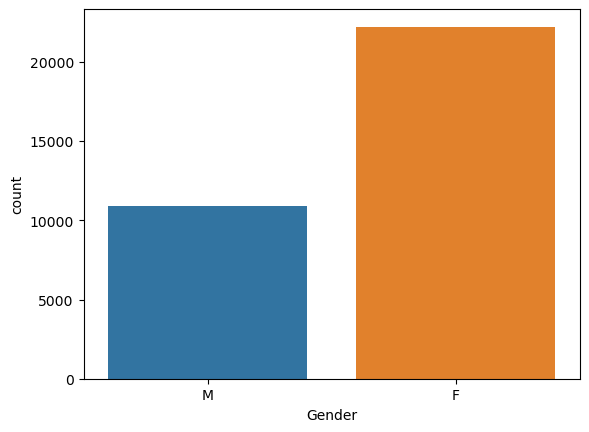

   Gender      Ratio
F   22220  67.109635
M   10890  32.890365
##########################################


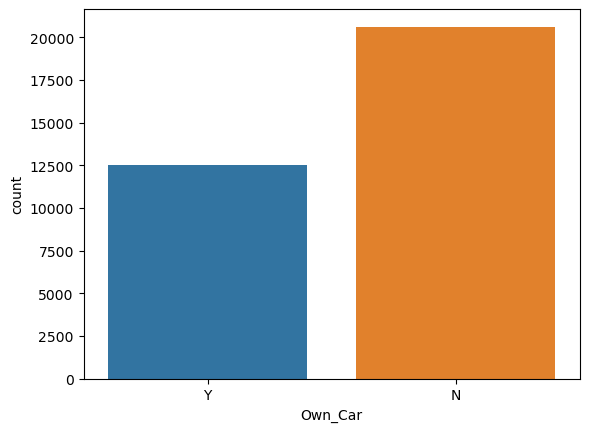

   Own_Car      Ratio
N    20618  62.271217
Y    12492  37.728783
##########################################


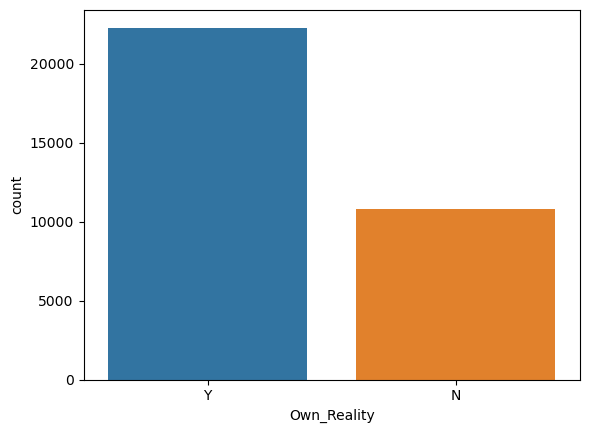

   Own_Reality      Ratio
Y        22288  67.315011
N        10822  32.684989
##########################################


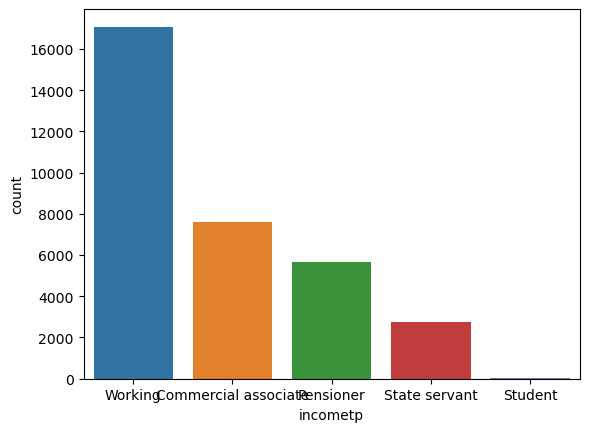

                      incometp      Ratio
Working                  17077  51.576563
Commercial associate      7627  23.035337
Pensioner                 5659  17.091513
State servant             2736   8.263365
Student                     11   0.033223
##########################################


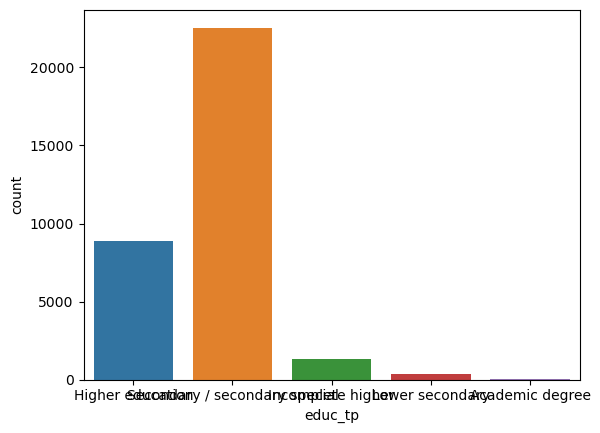

                               educ_tp      Ratio
Secondary / secondary special    22554  68.118393
Higher education                  8891  26.852915
Incomplete higher                 1292   3.902144
Lower secondary                    344   1.038961
Academic degree                     29   0.087587
##########################################


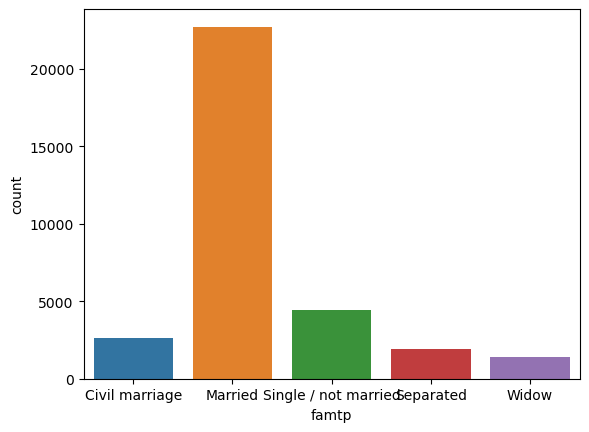

                      famtp      Ratio
Married               22725  68.634854
Single / not married   4433  13.388704
Civil marriage         2656   8.021746
Separated              1908   5.762609
Widow                  1388   4.192087
##########################################


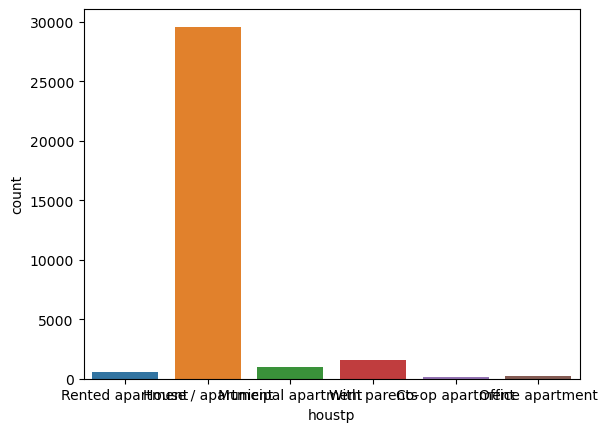

                     houstp      Ratio
House / apartment     29579  89.335548
With parents           1598   4.826336
Municipal apartment    1015   3.065539
Rented apartment        536   1.618846
Office apartment        242   0.730897
Co-op apartment         140   0.422833
##########################################


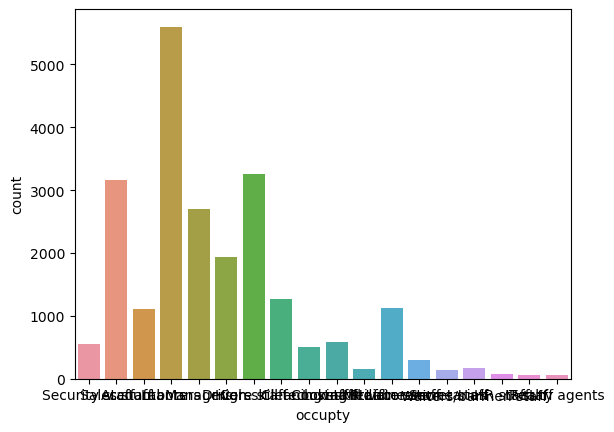

                       occupty      Ratio
Laborers                  5601  16.916339
Core staff                3250   9.815766
Sales staff               3156   9.531863
Managers                  2695   8.139535
Drivers                   1934   5.841136
High skill tech staff     1269   3.832679
Medicine staff            1124   3.394745
Accountants               1106   3.340381
Cooking staff              587   1.772878
Security staff             547   1.652069
Cleaning staff             511   1.543340
Private service staff      293   0.884929
Waiters/barmen staff       163   0.492298
Low-skill Laborers         159   0.480217
Secretaries                142   0.428873
HR staff                    76   0.229538
Realty agents               67   0.202356
IT staff                    57   0.172153
##########################################


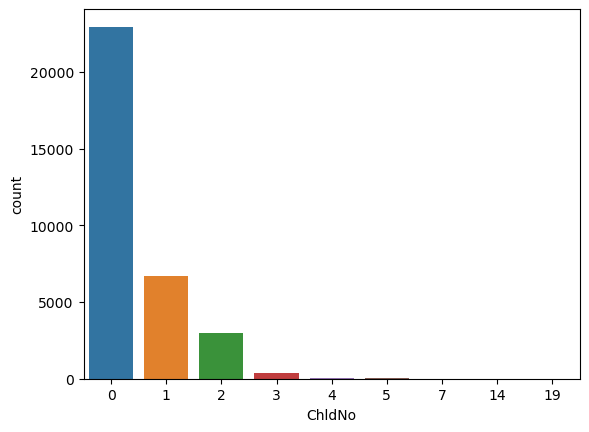

    ChldNo      Ratio
0    22959  69.341589
1     6731  20.329206
2     2967   8.961039
3      380   1.147690
4       52   0.157052
5       15   0.045304
14       3   0.009061
7        2   0.006040
19       1   0.003020
##########################################


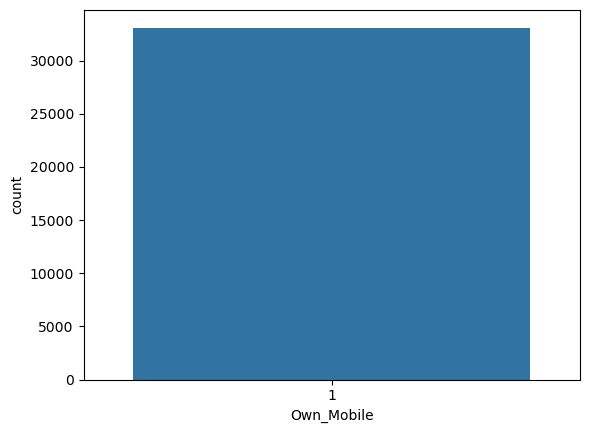

   Own_Mobile  Ratio
1       33110  100.0
##########################################


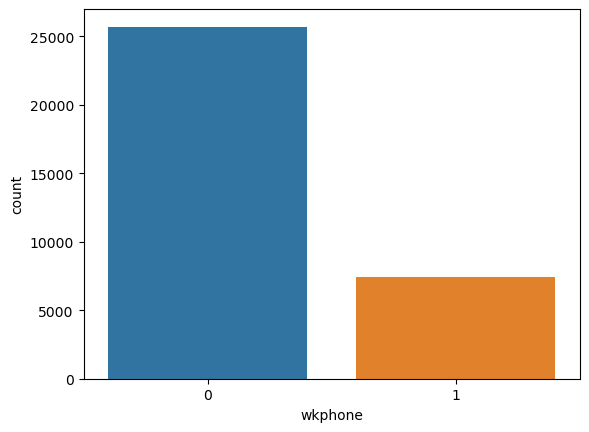

   wkphone      Ratio
0    25693  77.598913
1     7417  22.401087
##########################################


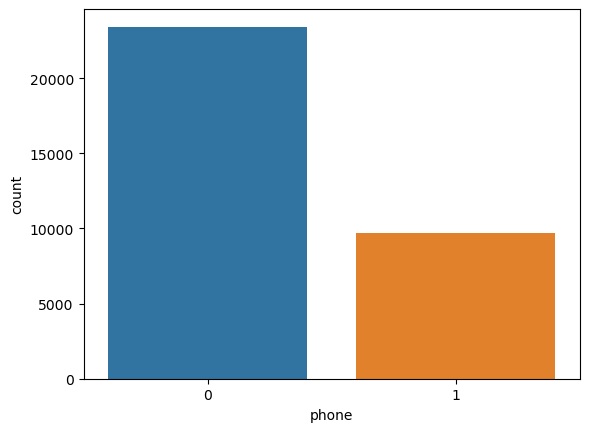

   phone      Ratio
0  23428  70.758079
1   9682  29.241921
##########################################


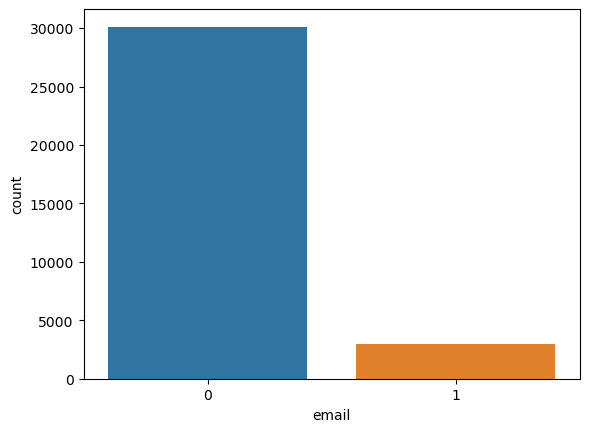

   email      Ratio
0  30117  90.960435
1   2993   9.039565
##########################################


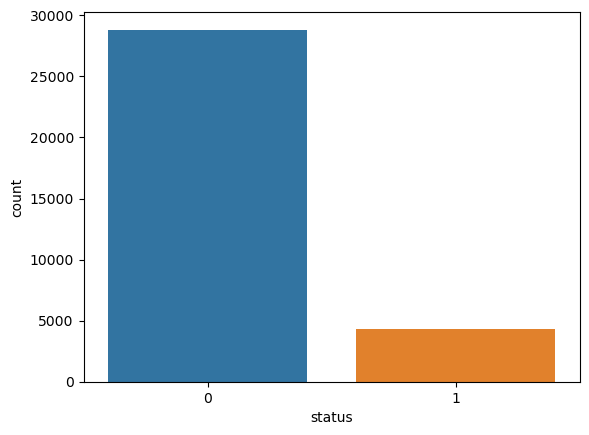

   status      Ratio
0   28819  87.040169
1    4291  12.959831
##########################################


In [13]:
for col in cat_cols:
    cat_summary(df, col,plot=True)

### Target Variable Analysis with Categorical Variable

In [14]:
for col in cat_cols:
    target_summary_with_cat(df,"status",col)

        RISK STATUS
Gender             
F          0.124122
M          0.140771
--------------------
         RISK STATUS
Own_Car             
N           0.132021
Y           0.125600
--------------------
             RISK STATUS
Own_Reality             
N               0.144243
Y               0.122487
--------------------
                      RISK STATUS
incometp                         
Commercial associate     0.141602
Pensioner                0.113801
State servant            0.140716
Student                  0.090909
Working                  0.127716
--------------------
                               RISK STATUS
educ_tp                                   
Academic degree                   0.241379
Higher education                  0.129119
Incomplete higher                 0.160217
Lower secondary                   0.113372
Secondary / secondary special     0.128137
--------------------
                      RISK STATUS
famtp                            
Civil marriage          

### Correlation Analysis

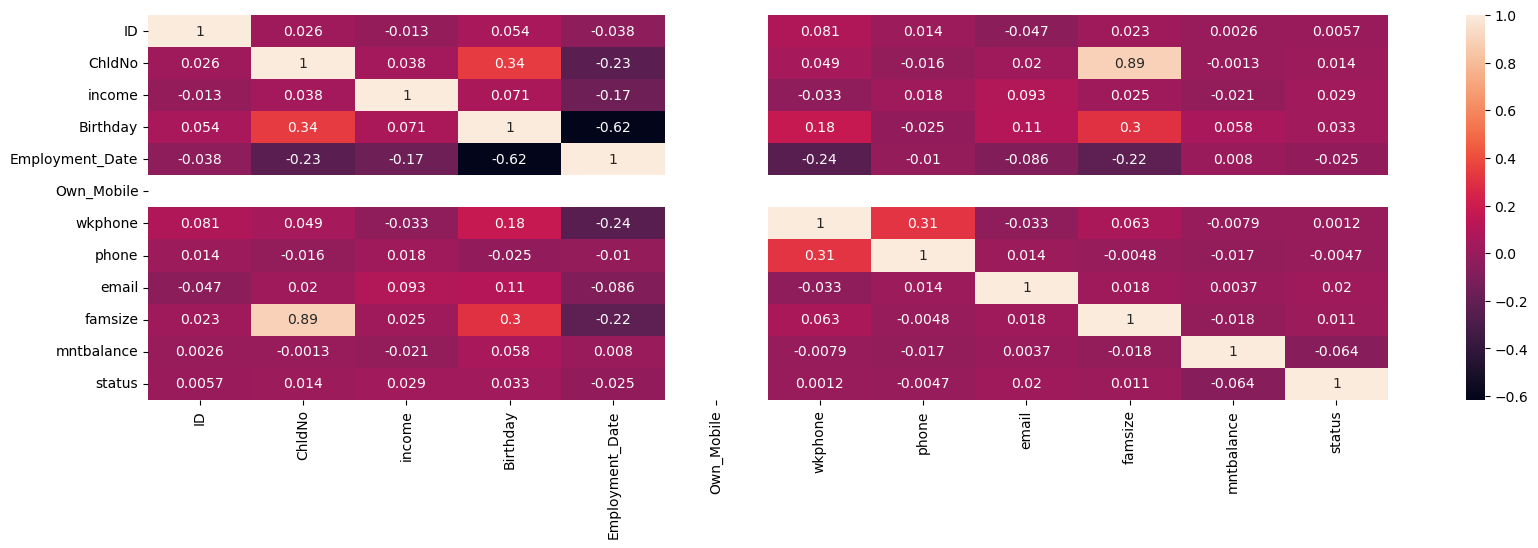

In [15]:
plt.figure(figsize = (20,5))
sns.heatmap(df.corr(),annot = True);

Text(0.5, 1.0, 'Correlation w.r.t Status')

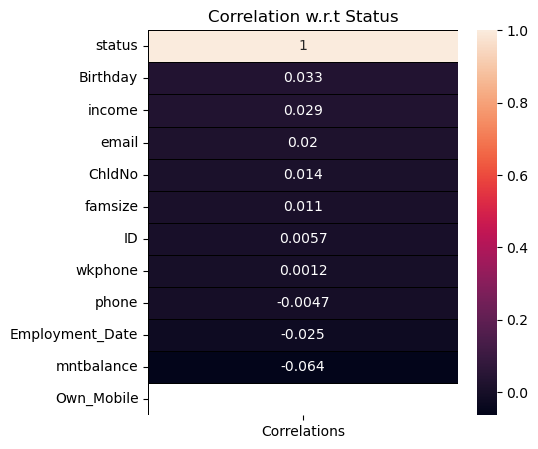

In [16]:
corr = df.corrwith(df['status']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,linewidths = 0.4,linecolor = 'black')
plt.title('Correlation w.r.t Status')

# Data Preparation

In [17]:
df.nunique()

ID                 33110
Gender                 2
Own_Car                2
Own_Reality            2
ChldNo                 9
income               258
incometp               5
educ_tp                5
famtp                  5
houstp                 6
Birthday            6960
Employment_Date     3566
Own_Mobile             1
wkphone                2
phone                  2
email                  2
occupty               18
famsize               10
mntbalance            61
status                 2
dtype: int64

In [18]:
df = df.drop(['ID',"Own_Mobile"],axis=1)

In [19]:
df["status"].value_counts()

0    28819
1     4291
Name: status, dtype: int64

In [20]:
# Missing Data Analysis

In [21]:
missing_values_table(df)

         n_miss  ratio
occupty   10373  31.33


In [22]:
# - Filling in missing data by assigning with independent variables

df.loc[(df["occupty"].isnull()) & (df["educ_tp"] == "Secondary / secondary special") &
       (df["incometp"] == "Pensioner"),"occupty" ] = "pensioner_labors"


df.loc[(df["occupty"].isnull()) & (df["educ_tp"] == "Secondary / secondary special") &
       (df["incometp"] == "Working"),"occupty"] = "Laborers"

df.loc[(df["occupty"].isnull()) & (df["educ_tp"] == "Higher education") &
       (df["incometp"] == "Working"),"occupty"] = "High skill tech staff"

df.loc[(df["occupty"].isnull()) & (df["educ_tp"] == "Secondary / secondary special") &
       (df["incometp"] == "Commercial associate"),"occupty"] = "Core staff"

df['occupty'] =df['occupty'].replace(np.nan,'others')

In [23]:
df["occupty"].value_counts()

Laborers                 7513
pensioner_labors         4513
Core staff               3891
Sales staff              3156
Managers                 2695
others                   2498
High skill tech staff    2078
Drivers                  1934
Medicine staff           1124
Accountants              1106
Cooking staff             587
Security staff            547
Cleaning staff            511
Private service staff     293
Waiters/barmen staff      163
Low-skill Laborers        159
Secretaries               142
HR staff                   76
Realty agents              67
IT staff                   57
Name: occupty, dtype: int64

In [24]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


### Outlier Analysis

In [25]:
check_outlier(df,"income")
replace_with_thresholds(df,"income")
check_outlier(df,"income")

False

# Feature Extraction/Interactions

In [26]:
# Creating Age variable by Birthday variable
df["Age"] = round((df.Birthday/365)*-1)


# Creating new age categorical variable by Age
bins = [21, 34, 45, 57, 69]
labels = ['21-34', '35-45', '46-57', '58-69']
df['Age_category'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Creating Experience variable by Employment_Date variable
df["Experience"] = df.Employment_Date/365
df['Experience']=df['Experience'].apply(lambda v : int(v*-1) if v <0 else 0)


# Creating new experience categorical variable from experience by using spec. function
def map_experience_to_category(experience):
    if experience == 0:
        return 'No_experience'
    elif experience == 1:
        return '1 year_exp'
    elif 2 <= experience<= 3:
        return '2-3 years_exp'
    
    elif 4 <= experience<= 5:
        return '4-5 years_exp'
    elif 6 <= experience<= 10:
        return '6-10 years_exp'
    elif 11 <= experience<= 15:
        return '11-15 years_exp'

    elif 16 <= experience<= 20:
        return '16-20 years_exp'

    elif 21 <= experience<= 30:
        return '21-30 years_exp'

    else:
        return '30+ years_experience'

df['Experience_category'] = df['Experience'].apply(map_experience_to_category)



# Creating new month_balance categorical variable from month_balance by using spec. function
def map_month_to_category(month):
    if month == 0:
        return 'Current Month'
    elif month == -1:
        return '1 month ago'
    elif month == -2:
        return '2 months ago'
    elif month == -3:
        return '3 months ago'
    elif month == -4:
        return '4 months ago'
    elif -12 <= month <= -5:
        return '5-12 months ago'

    elif -24 <= month < -12:
        return '12-24 months ago'

    elif -36 <= month < 24:
        return '25-36 months ago'

    else:
        return 'More than 36 months ago'

df['monthbalance_category'] = df['mntbalance'].apply(map_month_to_category)



# Creating new income categorical variable by Age
df['income_category'] = pd.qcut(df['income'], q=4, labels=['Low', 'Medium', 'High','Very High'])

In [27]:
# Replace variables
df["Gender"] =  df['Gender'].replace(['F','M'],[0,1])
df["Own_Car"] = df["Own_Car"].replace(["Y","N"],[1,0])
df["Own_Reality"] = df["Own_Reality"].replace(["Y","N"],[1,0])
df["Is_Working"] = df["incometp"].replace(["Working","Commercial associate","State servant","Pensioner","Student"],[1,1,1,0,0])


# Defining famsize variables again
df['famsize'] = df['famsize'].astype(object)
df.loc[df['famsize'] >= 4,'famsize']='4More'

In [28]:
# Defining feature interaction for occupty and houstp variables
df.loc[(df['occupty']=='Cleaning staff') | (df['occupty']=='Cooking staff') | (df['occupty']=='Drivers') |
       (df['occupty']=='Laborers') | (df['occupty']=='Low-skill Laborers') | (df['occupty']=='Security staff') |
       (df['occupty']=='Waiters/barmen staff') ,'occupty']='Laborwk'


df.loc[(df['occupty']=='Accountants') | (df['occupty']=='Core staff') | (df['occupty']=='HR staff') |
       (df['occupty']=='Medicine staff') | (df['occupty']=='Private service staff') | (df['occupty']=='Realty agents') |
       (df['occupty']=='Sales staff') | (df['occupty']=='Secretaries'),'occupty']='officewk'

df.loc[(df['occupty']=='Managers') | (df['occupty']=='High skill tech staff') | (df['occupty']=='IT staff'),'occupty']='hightecwk'


In [29]:
# Drop Employment_Date and Birthday variables
df = df.drop(columns=['Employment_Date','Birthday'])
df.head()

,Gender,Own_Car,Own_Reality,ChldNo,income,incometp,educ_tp,famtp,houstp,wkphone,...,famsize,mntbalance,status,Age,Age_category,Experience,Experience_category,monthbalance_category,income_category,Is_Working
0,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,2.0,-15,1,33.0,21-34,12,11-15 years_exp,12-24 months ago,Very High,1
1,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,2.0,-14,1,33.0,21-34,12,11-15 years_exp,12-24 months ago,Very High,1
2,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,...,2.0,-29,0,59.0,58-69,3,2-3 years_exp,25-36 months ago,Low,1
3,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,...,1.0,-4,0,52.0,46-57,8,6-10 years_exp,4 months ago,Very High,1
4,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,...,1.0,-26,0,52.0,46-57,8,6-10 years_exp,25-36 months ago,Very High,1


## Encoding / Scaling

In [30]:
df1 = df.copy()

In [31]:
# Performing one hot enconding for categorical variables
cat_cols, num_cols, cat_but_car = grab_col_names(df1)
cat_cols = [col for col in cat_cols if "status" not in col]

df1 = one_hot_encoder(df1, cat_cols, drop_first=True)
df1.head()

,income,mntbalance,status,Age,Experience,incometp_Pensioner,incometp_State servant,incometp_Student,incometp_Working,educ_tp_Higher education,...,wkphone_1,phone_1,email_1,Age_category_35-45,Age_category_46-57,Age_category_58-69,income_category_Medium,income_category_High,income_category_Very High,Is_Working_1
0,427500.0,-15,1,33.0,12,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,1
1,427500.0,-14,1,33.0,12,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,1
2,112500.0,-29,0,59.0,3,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,270000.0,-4,0,52.0,8,0,0,0,0,0,...,0,1,1,0,1,0,0,0,1,1
4,270000.0,-26,0,52.0,8,0,0,0,0,0,...,0,1,1,0,1,0,0,0,1,1


In [67]:
# Performing scaling for numerical variables
X_scaled = MinMaxScaler().fit_transform(df1[num_cols])
df1[num_cols] = pd.DataFrame(X_scaled, columns=df1[num_cols].columns)


In [70]:
df1.head()

,income,mntbalance,status,Age,Experience,incometp_Pensioner,incometp_State servant,incometp_Student,incometp_Working,educ_tp_Higher education,...,wkphone_1,phone_1,email_1,Age_category_35-45,Age_category_46-57,Age_category_58-69,income_category_Medium,income_category_High,income_category_Very High,Is_Working_1
0,0.528190,0.750000,1,0.250000,0.279070,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,1
1,0.528190,0.766667,1,0.250000,0.279070,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,1
2,0.112760,0.516667,0,0.791667,0.069767,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,0.320475,0.933333,0,0.645833,0.186047,0,0,0,0,0,...,0,1,1,0,1,0,0,0,1,1
4,0.320475,0.566667,0,0.645833,0.186047,0,0,0,0,0,...,0,1,1,0,1,0,0,0,1,1


In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.feature_selection import f_classif

In [33]:

def score_func_by_target(variables,score,target):
    features = df.loc[:, variables]
    target = df.loc[:, target]

    best_features = SelectKBest(score_func=score, k='all')
    fit = best_features.fit(features, target)

    featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['Chi Squared Score'])

    plt.subplots(figsize=(15, 5))
    sns.heatmap(featureScores.sort_values(ascending=False, by='Chi Squared Score'), annot=True, linewidths=0.4,
                linecolor='black', fmt='.2f');
    plt.title('Selection of Categorical Features')
    plt.show(block=True)

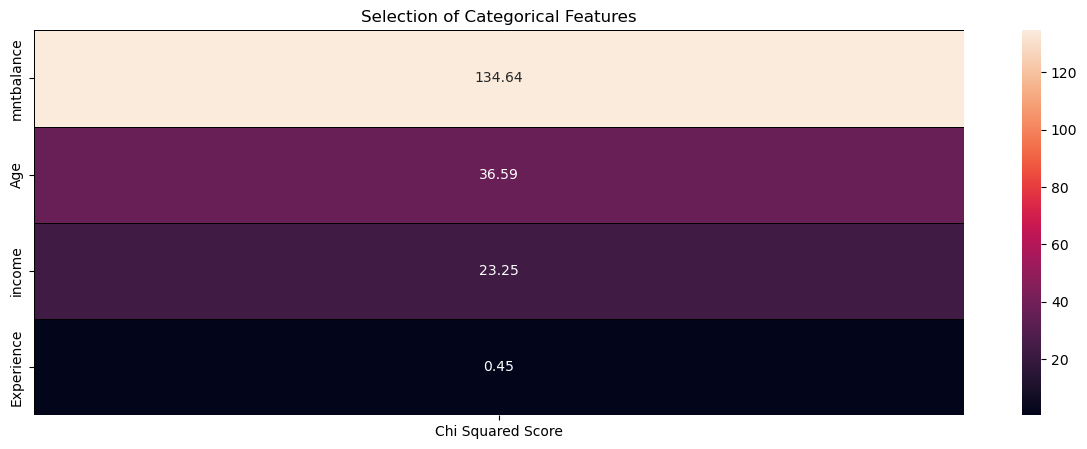

In [34]:
score_func_by_target(num_cols,f_classif,"status")

Text(0.5, 1.0, 'Correlation w.r.t Status')

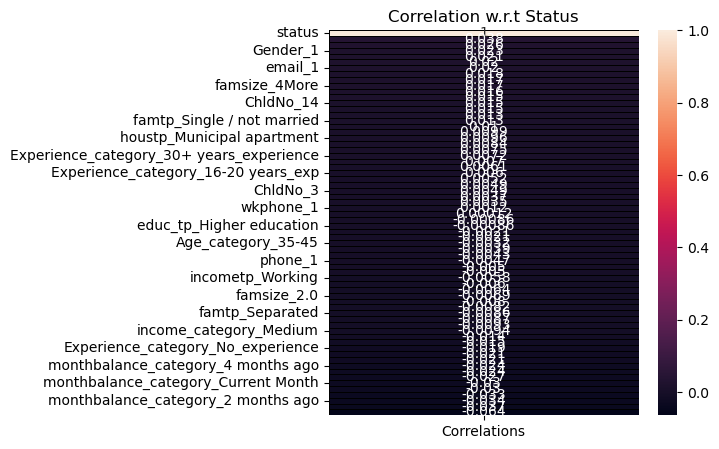

In [35]:
#  - Correlation Analysis
corr = df1.corrwith(df['status']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,linewidths = 0.4,linecolor = 'black')
plt.title('Correlation w.r.t Status')

# Modeling

In [36]:
y = df1["status"]
X = df1.drop(["status"], axis=1)

In [37]:
# Splitting the model into train/test split
X_train, X_test, y_train, y_test,classifiers = train_test(X,y)

Base Models....
[('CART', DecisionTreeClassifier(random_state=0)), ('RF', RandomForestClassifier(random_state=0)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)), ('LightGBM', LGBMClassifier(random_state=0, verbose=-1))]


C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


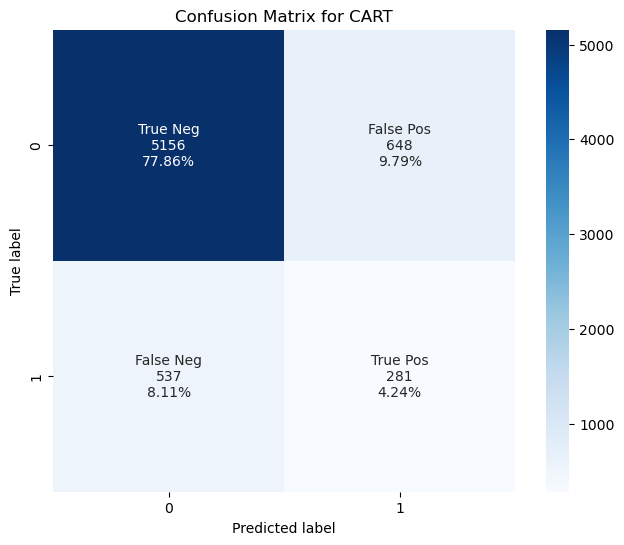

Classification Report for CART:

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5804
           1       0.30      0.34      0.32       818

    accuracy                           0.82      6622
   macro avg       0.60      0.62      0.61      6622
weighted avg       0.83      0.82      0.83      6622



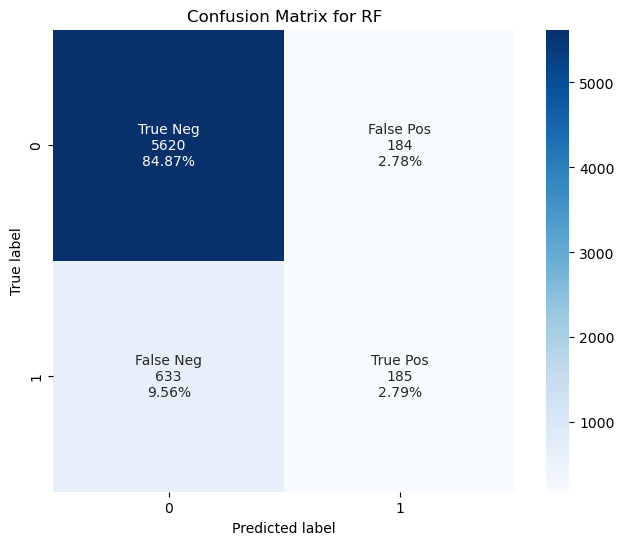

Classification Report for RF:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5804
           1       0.50      0.23      0.31       818

    accuracy                           0.88      6622
   macro avg       0.70      0.60      0.62      6622
weighted avg       0.85      0.88      0.86      6622



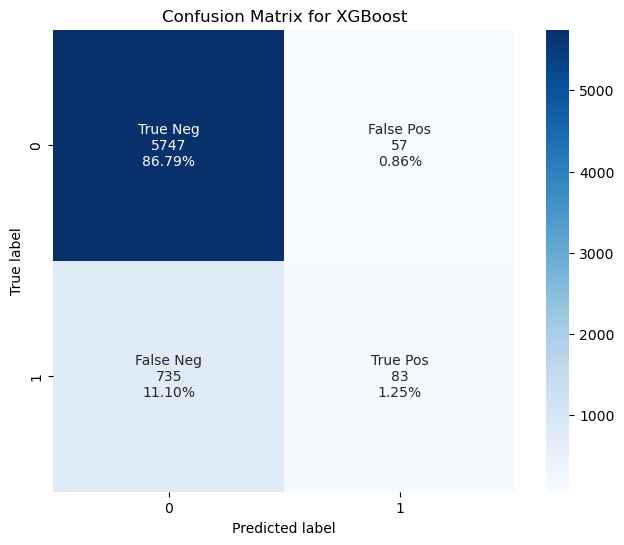

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      5804
           1       0.59      0.10      0.17       818

    accuracy                           0.88      6622
   macro avg       0.74      0.55      0.55      6622
weighted avg       0.85      0.88      0.84      6622



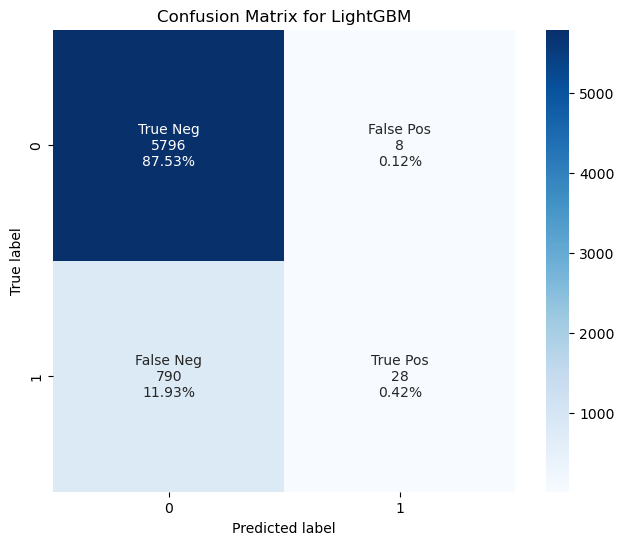

Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      5804
           1       0.78      0.03      0.07       818

    accuracy                           0.88      6622
   macro avg       0.83      0.52      0.50      6622
weighted avg       0.87      0.88      0.83      6622



In [38]:
# Model success evaluation with Hold-Out via the complexity matrix
model_evaluation(classifiers,X_test,y_test,X_train,y_train)

In [39]:
# Model success evaluation with K-Fold Cross Validation
models(classifiers,X,y)

Classifier: CART
Cross Validation Scores:
Accuracy :  81.38%
F1 :  31.96%
Precision :  30.71%
Recall :  33.34%
Test Accuracy :  82.11%
Classifier: RF
Cross Validation Scores:
Accuracy :  86.74%
F1 :  27.62%
Precision :  48.67%
Recall :  19.29%
Test Accuracy :  87.66%


C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Classifier: XGBoost
Cross Validation Scores:
Accuracy :  87.07%
F1 :  13.21%
Precision :  54.96%
Recall :  7.52%
Test Accuracy :  88.04%
Classifier: LightGBM
Cross Validation Scores:
Accuracy :  87.03%
F1 :  4.12%
Precision :  66.09%
Recall :  2.13%
Test Accuracy :  87.95%


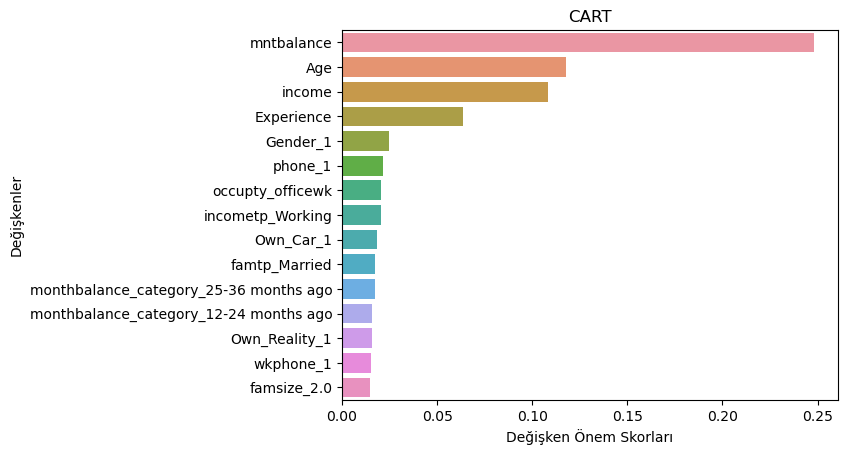

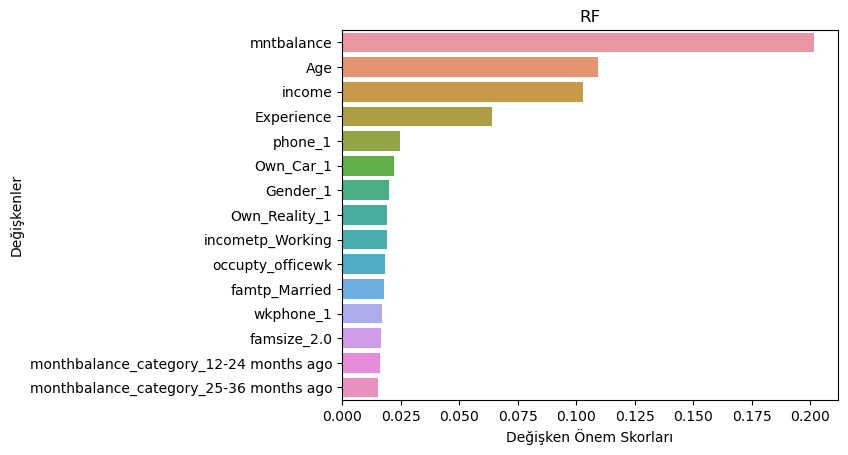

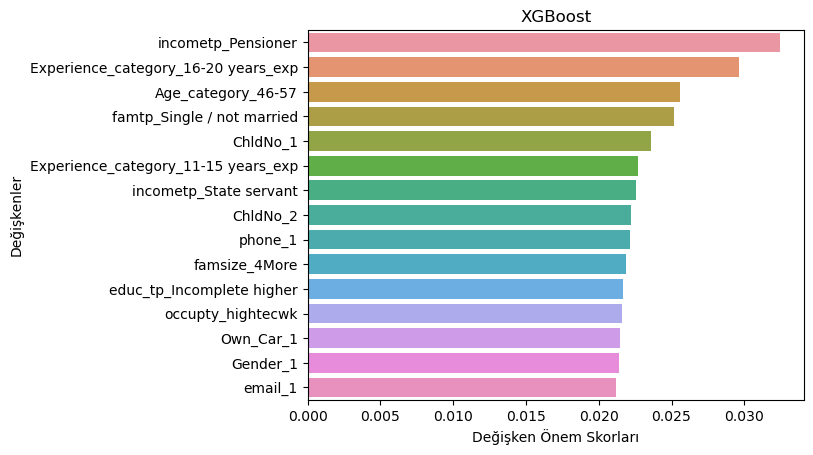

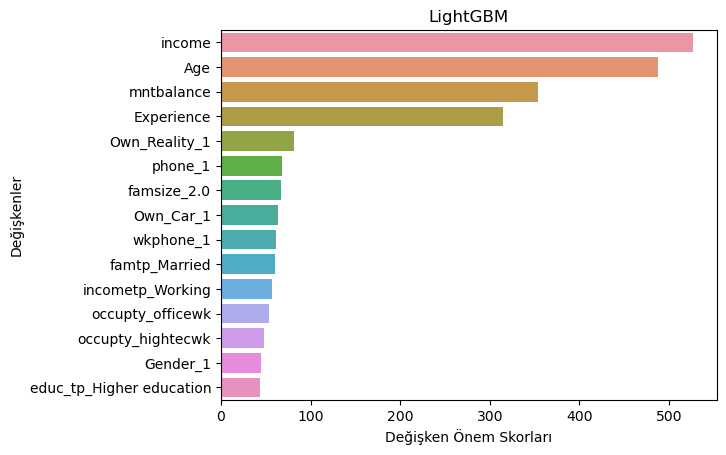

In [46]:
# Feature Importance chart of each classifier model
feature_importances(classifiers,X,y,count=15)

#### Comments:

* CART, RandomForest and LightGBM algorithms were especially effective on numerical variables such as "income, age, mntbalance".

* XGBoost affects especially categorical variables.

### Bonus : Dengesiz Veri Setlerine Özel Çalışma

In [47]:
weights = class_weight.compute_sample_weight('balanced', y_train)
gbm_model = GradientBoostingClassifier(n_estimators=500,random_state=42)
gbm_model.fit(X_train, y_train, sample_weight=weights)
y_pred = gbm_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[3687 2117]
 [ 342  476]]
              precision    recall  f1-score   support

           0       0.92      0.64      0.75      5804
           1       0.18      0.58      0.28       818

    accuracy                           0.63      6622
   macro avg       0.55      0.61      0.51      6622
weighted avg       0.82      0.63      0.69      6622



In [48]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'learning_rate': 0.05,
    'num_leaves': 30,
}

z_train = lgb.Dataset(X_train, label=y_train)

lgbm = lgb.train(params, z_train, num_boost_round=1000)

y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

# Performans değerlendirme
print(confusion_matrix(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3473, number of negative: 23015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 26488, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131116 -> initscore=-1.891127
[LightGBM] [Info] Start training from score -1.891127
[[4790 1014]
 [ 416  402]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      5804
           1       0.28      0.49      0.36       818

    accuracy                           0.78      6622
   macro avg       0.60      0.66      0.62      6622
weighted avg       0.84      0.78      0.81      6622



# UnderSampling: RandomUnderSampler

In [49]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
undersample = RandomUnderSampler(random_state=0)
X_undersample, y_undersample = undersample.fit_resample(X, y)

counter = Counter(y_undersample)

In [50]:
# Splitting the model into train/test split
X_train, X_test, y_train, y_test,classifiers = train_test(X_undersample,y_undersample)

Base Models....
[('CART', DecisionTreeClassifier(random_state=0)), ('RF', RandomForestClassifier(random_state=0)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)), ('LightGBM', LGBMClassifier(random_state=0, verbose=-1))]


C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


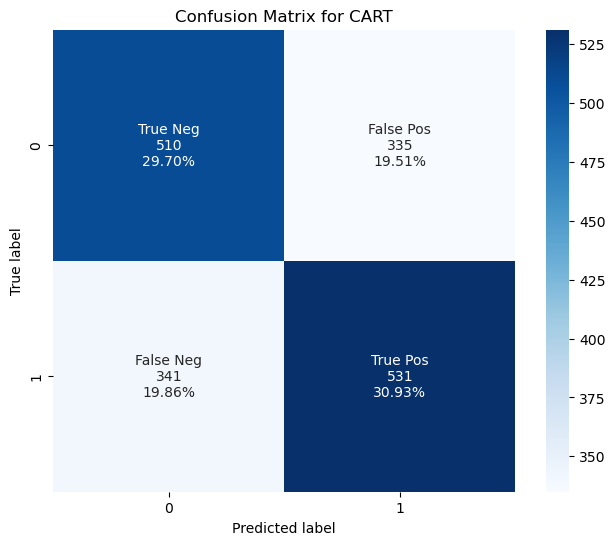

Classification Report for CART:

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       845
           1       0.61      0.61      0.61       872

    accuracy                           0.61      1717
   macro avg       0.61      0.61      0.61      1717
weighted avg       0.61      0.61      0.61      1717



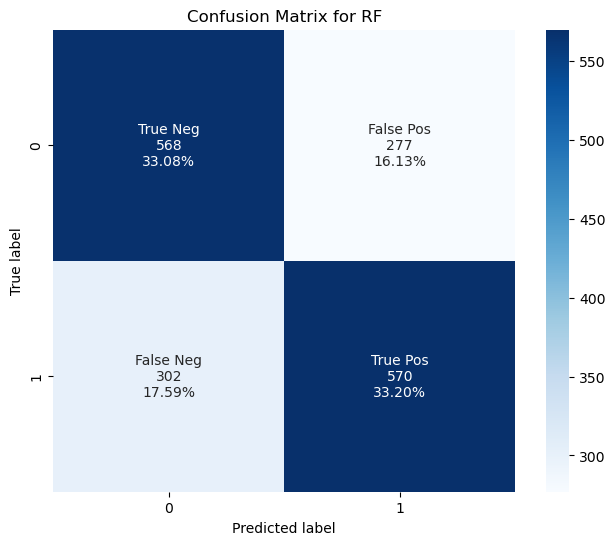

Classification Report for RF:

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       845
           1       0.67      0.65      0.66       872

    accuracy                           0.66      1717
   macro avg       0.66      0.66      0.66      1717
weighted avg       0.66      0.66      0.66      1717



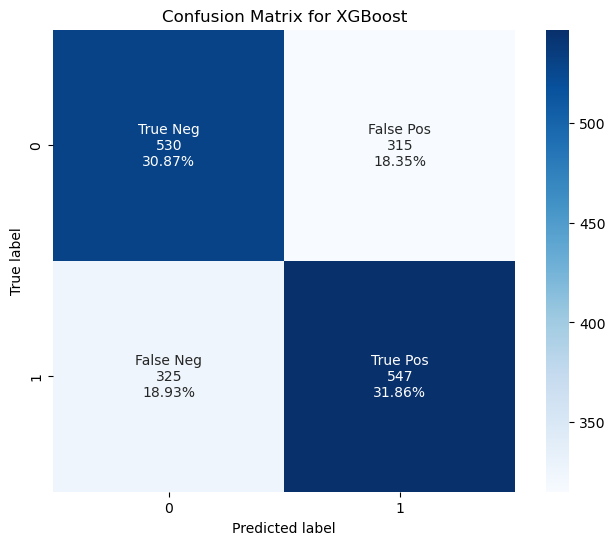

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.62      0.63      0.62       845
           1       0.63      0.63      0.63       872

    accuracy                           0.63      1717
   macro avg       0.63      0.63      0.63      1717
weighted avg       0.63      0.63      0.63      1717



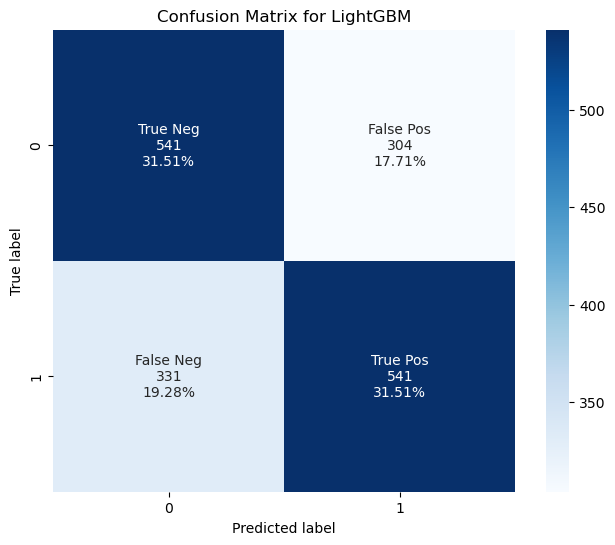

Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       845
           1       0.64      0.62      0.63       872

    accuracy                           0.63      1717
   macro avg       0.63      0.63      0.63      1717
weighted avg       0.63      0.63      0.63      1717



In [51]:
# Model success evaluation with Hold-Out via the complexity matrix
model_evaluation(classifiers,X_test,y_test,X_train,y_train)

In [52]:
# Model success evaluation with K-Fold Cross Validation
models(classifiers,X_undersample,y_undersample)

Classifier: CART
Cross Validation Scores:
Accuracy :  58.40%
F1 :  58.86%
Precision :  58.00%
Recall :  59.75%
Test Accuracy :  60.63%
Classifier: RF
Cross Validation Scores:
Accuracy :  62.16%
F1 :  61.93%
Precision :  62.11%
Recall :  61.83%
Test Accuracy :  66.28%


C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Classifier: XGBoost
Cross Validation Scores:
Accuracy :  59.58%
F1 :  59.93%
Precision :  59.19%
Recall :  60.69%
Test Accuracy :  62.73%
Classifier: LightGBM
Cross Validation Scores:
Accuracy :  59.80%
F1 :  60.08%
Precision :  59.46%
Recall :  60.75%
Test Accuracy :  63.02%


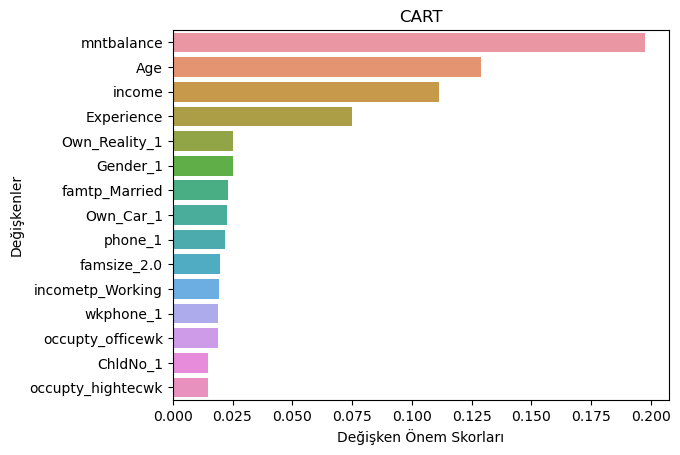

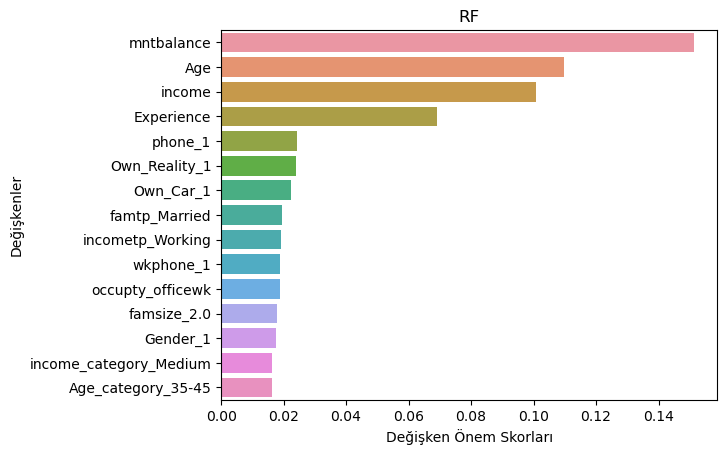

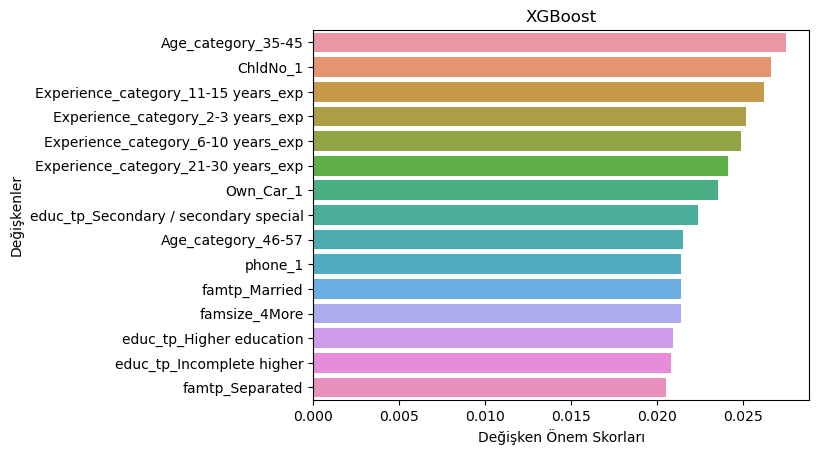

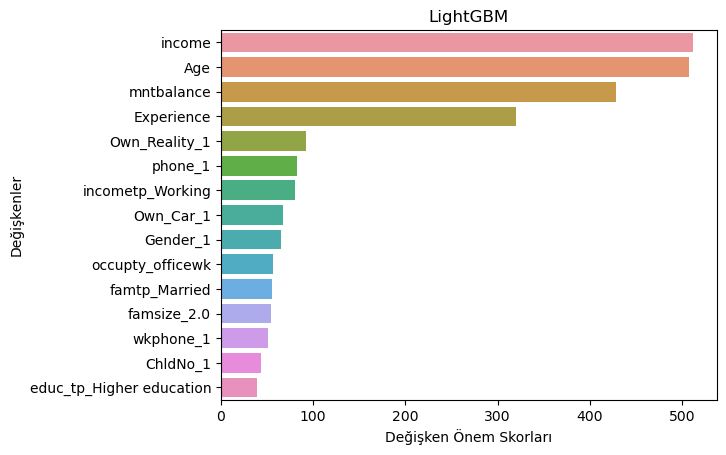

In [53]:
# Feature Importance chart of each classifier model
feature_importances(classifiers,X_undersample,y_undersample,count=15)

# UnderSampling: TomekLinks

In [56]:
from imblearn.under_sampling import TomekLinks

# Tomek Links uygulayalım
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)


In [57]:
# Splitting the model into train/test split
X_train, X_test, y_train, y_test,classifiers = train_test(X_resampled,y_resampled)

Base Models....
[('CART', DecisionTreeClassifier(random_state=0)), ('RF', RandomForestClassifier(random_state=0)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)), ('LightGBM', LGBMClassifier(random_state=0, verbose=-1))]


C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


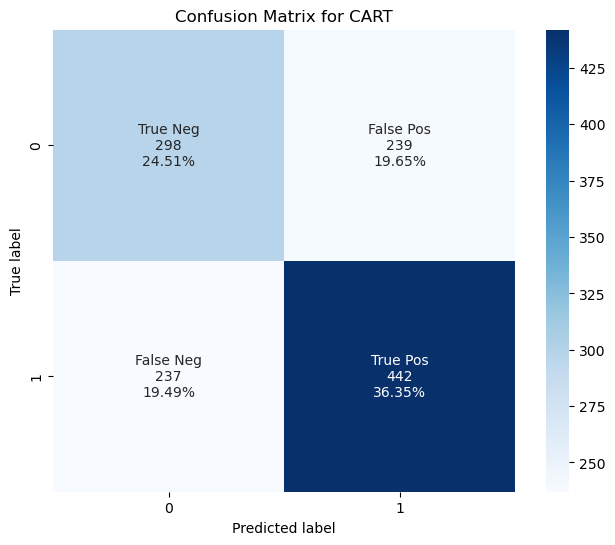

Classification Report for CART:

              precision    recall  f1-score   support

           0       0.56      0.55      0.56       537
           1       0.65      0.65      0.65       679

    accuracy                           0.61      1216
   macro avg       0.60      0.60      0.60      1216
weighted avg       0.61      0.61      0.61      1216



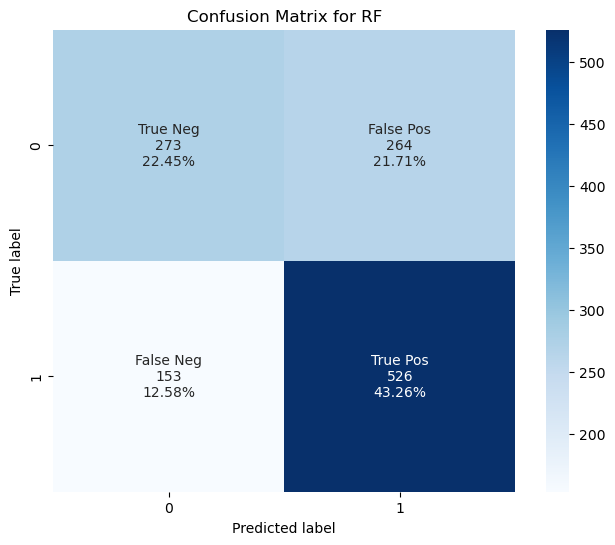

Classification Report for RF:

              precision    recall  f1-score   support

           0       0.64      0.51      0.57       537
           1       0.67      0.77      0.72       679

    accuracy                           0.66      1216
   macro avg       0.65      0.64      0.64      1216
weighted avg       0.65      0.66      0.65      1216



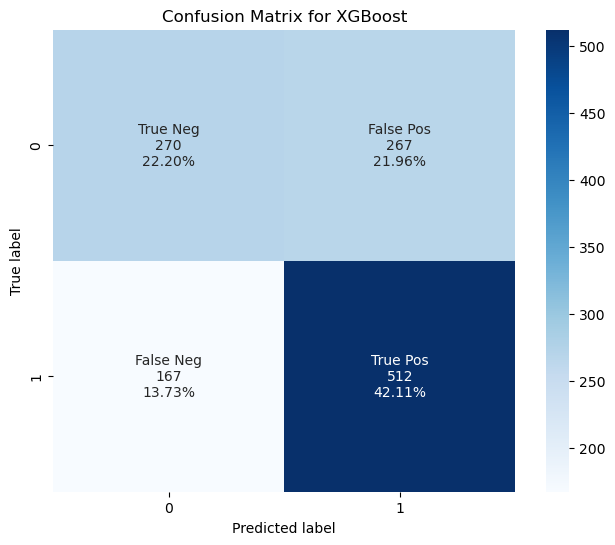

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       537
           1       0.66      0.75      0.70       679

    accuracy                           0.64      1216
   macro avg       0.64      0.63      0.63      1216
weighted avg       0.64      0.64      0.64      1216



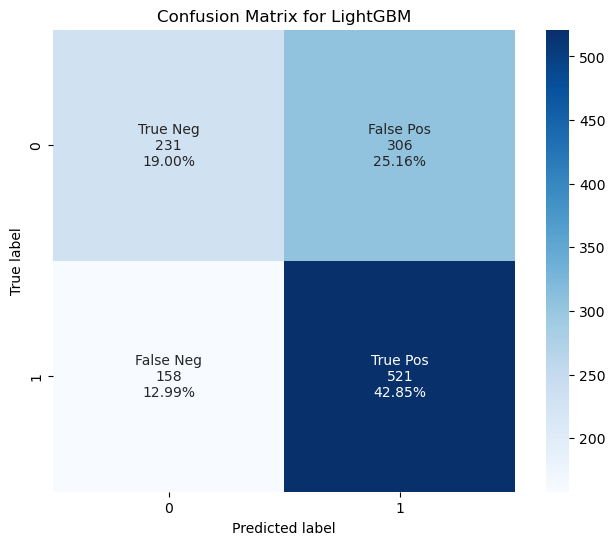

Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.59      0.43      0.50       537
           1       0.63      0.77      0.69       679

    accuracy                           0.62      1216
   macro avg       0.61      0.60      0.60      1216
weighted avg       0.61      0.62      0.61      1216



In [58]:
# Model success evaluation with Hold-Out via the complexity matrix
model_evaluation(classifiers,X_test,y_test,X_train,y_train)

In [59]:
# Model success evaluation with K-Fold Cross Validation
models(classifiers,X_undersample,y_undersample)

Classifier: CART
Cross Validation Scores:
Accuracy :  59.42%
F1 :  64.17%
Precision :  63.83%
Recall :  64.53%
Test Accuracy :  60.86%
Classifier: RF
Cross Validation Scores:
Accuracy :  63.92%
F1 :  70.42%
Precision :  65.43%
Recall :  76.24%
Test Accuracy :  65.71%


C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\gurkanc\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Classifier: XGBoost
Cross Validation Scores:
Accuracy :  62.44%
F1 :  68.13%
Precision :  65.27%
Recall :  71.28%
Test Accuracy :  64.31%
Classifier: LightGBM
Cross Validation Scores:
Accuracy :  61.60%
F1 :  68.94%
Precision :  63.31%
Recall :  75.69%
Test Accuracy :  61.84%


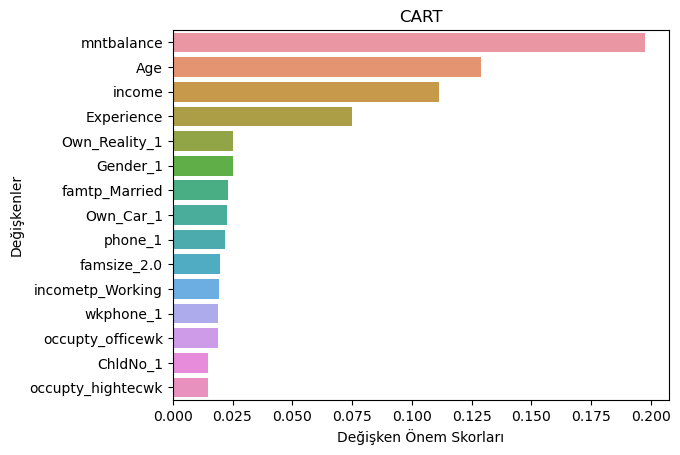

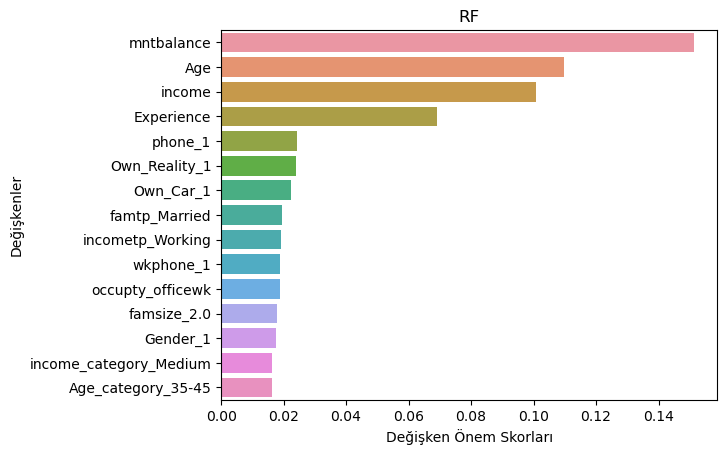

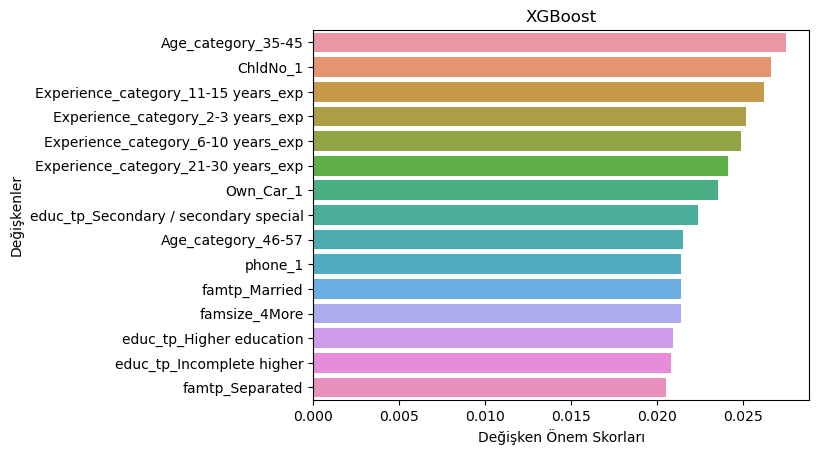

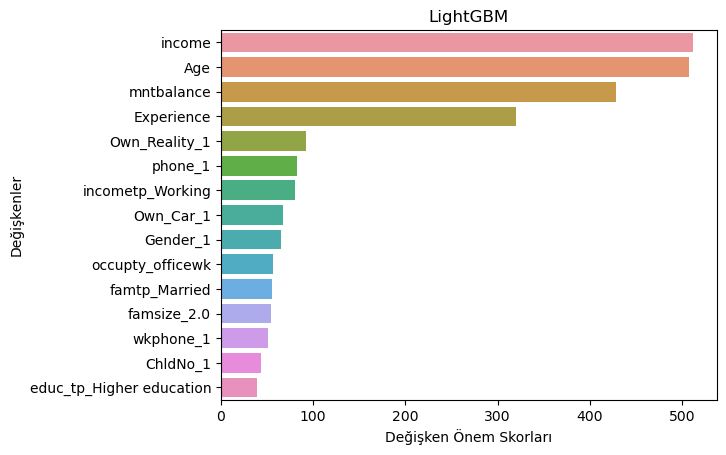

In [60]:
# Feature Importance chart of each classifier model
feature_importances(classifiers,X_undersample,y_undersample)

# Hyperparameter Optimization

In [61]:
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30) }

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "sqrt"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300,500]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100,200,500],
                  "colsample_bytree": [0.5, 1],}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500,1000],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 250, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128, 255],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced']
}

classifiers = [#('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(random_state=42), cart_params),
               ("RF", RandomForestClassifier(random_state=42), rf_params),
               ('XGBoost', xgb.XGBClassifier(eval_metric='logloss',random_state=42), xgboost_params),
               ('LightGBM', LGBMClassifier(random_state=42,verbose=-1), lightgbm_params),]
                #('CatBoost', CatBoostClassifier(verbose=False),catboost_params)]


In [62]:
best_models = hyperparameter_optimization(X_undersample,y_undersample,classifiers)


Hyperparameter Optimization....
########## CART ##########
accuracy (Before): 0.5112
f1 (Before): 0.4569
recall (Before): 0.4111
precision (Before): 0.5144
CART best params: {'min_samples_split': 17, 'max_depth': 2}
accuracy (After): 0.5456
f1 (After): 0.6669
recall (After): 0.9098
precision (After): 0.5263
########## RF ##########
accuracy (Before): 0.521
f1 (Before): 0.4307
recall (Before): 0.3631
precision (Before): 0.5299
RF best params: {'n_estimators': 300, 'min_samples_split': 20, 'max_features': 5, 'max_depth': 15}
accuracy (After): 0.5362
f1 (After): 0.4986
recall (After): 0.4626
precision (After): 0.5417
########## XGBoost ##########
accuracy (Before): 0.5151
f1 (Before): 0.4545
recall (Before): 0.4041
precision (Before): 0.5193
XGBoost best params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
accuracy (After): 0.5267
f1 (After): 0.5072
recall (After): 0.4882
precision (After): 0.5282
########## LightGBM ##########
accuracy (Before): 0.

## Optimization Result

In [63]:
model_results_df = pd.DataFrame(columns=['Model', 'Metric', 'Before Optimization', 'After Optimization'])

for name, model_info in best_models.items():
    for metric in model_info['initial_scores']:
        before_score = model_info['initial_scores'][metric]
        after_score = model_info['optimized_scores'][metric]
        model_results_df = model_results_df.append({
            'Model': name,
            'Metric': metric,
            'Before Optimization': before_score,
            'After Optimization': after_score
        }, ignore_index=True)

print(model_results_df)

       Model     Metric  Before Optimization  After Optimization
0       CART   accuracy               0.5112              0.5456
1       CART         f1               0.4569              0.6669
2       CART     recall               0.4111              0.9098
3       CART  precision               0.5144              0.5263
4         RF   accuracy               0.5210              0.5362
5         RF         f1               0.4307              0.4986
6         RF     recall               0.3631              0.4626
7         RF  precision               0.5299              0.5417
8    XGBoost   accuracy               0.5151              0.5267
9    XGBoost         f1               0.4545              0.5072
10   XGBoost     recall               0.4041              0.4882
11   XGBoost  precision               0.5193              0.5282
12  LightGBM   accuracy               0.5228              0.5287
13  LightGBM         f1               0.4705              0.4979
14  LightGBM     recall  